# Fine-tuning image captioning model

Using ViT and GPT

In [22]:
from transformers import VisionEncoderDecoderModel, GPT2TokenizerFast, AutoFeatureExtractor, AutoTokenizer, TrainingArguments, Trainer


from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset
import torch
import numpy as np
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, Resize
import pandas as pd

import requests
from io import BytesIO

The VisionEncoderDecoderModel takes in 2 models, one for encoder and one for decoder

In [2]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    'google/vit-base-patch16-224-in21k', # For encoder
    'distilgpt2' # For decoder
)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.2.crossattention.c_attn.bias', 'transformer.h.2.crossattention.c_attn.weight', 'transformer.h.2.crossattention.c_proj.bias', 'transformer.h.2.cr

In [3]:
model

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (inte

While analysing the model, we can notice a statement saying: weights were not initialized from the checkpoint and loaded randomly

The reason for that is that those weights are for cross attention and ViT doesn't have cross attention.

ViT just outputs `key` and `value` matrices as normal encoders

on the other hand GPT-2 (decoder-based) need cross-attention to combine those matrices to its `query` matrix

In [3]:
type(model.encoder)

transformers.models.vit.modeling_vit.ViTModel

In [4]:
type(model.decoder)

transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel

In [ ]:
# total number of parameters in the end combined model

total_params = 0
for param in model.parameters():
    total_params += param.numel()

print(f"Our model has a combined {total_params:,} parameters")

Our model has a combined 182,485,248 parameters


In [18]:
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained('distilgpt2')

In [24]:
IMAGES_PATH = '../../data/flicker_images'
MIN_CAPTION, MAX_CAPTION = 10, 50

def load_captions_data(filename):
    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            if img_name.endswith("jpg"):
                caption = caption.replace(' .', '').strip()
                tokens = caption.strip().split()
                if len(caption) < MIN_CAPTION or len(caption) > MAX_CAPTION:
                    continue
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        return caption_mapping, text_data

# Load the dataset
captions_mapping, text_data = load_captions_data("../../data/Flickr8k.token.txt")

In [25]:
list(captions_mapping.items())[:5]

[('../../data/flicker_images/1000268201_693b08cb0e.jpg',
  ['A girl going into a wooden building',
   'A little girl climbing into a wooden playhouse',
   'A little girl climbing the stairs to her playhouse']),
 ('../../data/flicker_images/1001773457_577c3a7d70.jpg',
  ['A black dog and a spotted dog are fighting',
   'Two dogs on pavement moving toward each other']),
 ('../../data/flicker_images/1003163366_44323f5815.jpg',
  ['A man lays on a bench while his dog sits by him',
   'A shirtless man lies on a park bench with his dog']),
 ('../../data/flicker_images/1007129816_e794419615.jpg',
  ['A man in an orange hat starring at something',
   'A man wears an orange hat and glasses']),
 ('../../data/flicker_images/1007320043_627395c3d8.jpg',
  ['A child playing on a rope net', 'A little girl climbing on red roping'])]

In [26]:
feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

feature_extractor

ViTFeatureExtractor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [27]:
normalize = Normalize(
    mean=feature_extractor.image_mean, 
    std=feature_extractor.image_std
)

crop_size = feature_extractor.size
if isinstance(crop_size, dict):
    crop_size = (crop_size["height"], crop_size["width"])

_transforms = Compose(
    [
        RandomResizedCrop(crop_size),
        ToTensor(),
        normalize
    ]
)

This is a compose object that takes in raw image and performs 3 operations:

> Randomly crop the image and resize it to the feature extractor size i.e. 224x224

> Convert it to a Tensor i.e. Pytorch tensor

> Normalize the pixels by the mean and std so the pixel values look similar to what model has already seen in the pre-training process

RandomResizedCrop is data augmentation tool

By cropping the image randomly, the captioning task would get tougher but it pushes the model to generalize better

So as we have multiple captions for same image, by randomly cropping the image from different parts, the risk of overfitting the model is reduced

In [28]:
rows = []

# its ok to use multiple captions per image becuase of our data augmentation
for path, captions in captions_mapping.items():
    for caption in captions:
        rows.append({'path': path, 'caption': caption})

image_df = pd.DataFrame(rows)

image_dataset = Dataset.from_pandas(image_df)

In [12]:
image_df.shape

(19599, 2)

In [13]:
image_df.head()

path  \
0  ../../data/flicker_images/1000268201_693b08cb0...   
1  ../../data/flicker_images/1000268201_693b08cb0...   
2  ../../data/flicker_images/1000268201_693b08cb0...   
3  ../../data/flicker_images/1001773457_577c3a7d7...   
4  ../../data/flicker_images/1001773457_577c3a7d7...   

                                             caption  
0                A girl going into a wooden building  
1     A little girl climbing into a wooden playhouse  
2  A little girl climbing the stairs to her playh...  
3         A black dog and a spotted dog are fighting  
4      Two dogs on pavement moving toward each other

In [ ]:
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

def image_preprocess(examples):
    # ViT expects pixel_values instead of input_ids
    examples['pixel_values'] = [_transforms(Image.open(path)) for path in examples['path']]
    # Padding tokens here instead of using a datacollator
    tokenized = gpt2_tokenizer(
        examples['caption'], padding='max_length', max_length=10, truncation=True
    )['input_ids']
    # the output captions
    examples['labels'] = [[l if l != gpt2_tokenizer.pad_token_id else -100 for l in t] for t in tokenized]
    
    # delete unused keys
    del examples['path']
    del examples['caption']
    return examples

In [15]:
image_dataset = image_dataset.map(image_preprocess, batched=True)

Map: 100%|██████████| 19599/19599 [01:24<00:00, 232.04 examples/s]


In [16]:
image_dataset = image_dataset.train_test_split(test_size=0.1)

image_dataset

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 17639
    })
    test: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 1960
    })
})

In [ ]:
# Setting a pad token and a start token in the combined model to be the same as gpt2

model.config.pad_token = gpt2_tokenizer.pad_token
model.config.pad_token_id = gpt2_tokenizer.pad_token_id

model.config.decoder_start_token = gpt2_tokenizer.bos_token
model.config.decoder_start_token_id = gpt2_tokenizer.bos_token_id

In [18]:
# freeze all but the last two layers in the ViT
for name, param in model.encoder.named_parameters():
    if 'encoder.layer.10' in name:
        break
    param.requires_grad = False

In [19]:
training_args = TrainingArguments(
    output_dir='./v2_image_captioning', # The output directory
    overwrite_output_dir=True, # overwrite the content of the output directory
    num_train_epochs=4, # number of training epochs
    per_device_train_batch_size=64, # batch size for training
    per_device_eval_batch_size=64,  # batch size for evaluation
    load_best_model_at_end=True,
    log_level='info',
    logging_steps=50,
    eval_strategy='epoch',
    save_strategy='epoch',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=image_dataset['train'],
    eval_dataset=image_dataset['test'],
)

trainer.evaluate()


***** Running Evaluation *****
  Num examples = 1960
  Batch size = 64
/Users/niketgirdhar/.pyenv/versions/3.12.3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


{'eval_loss': 9.591801643371582,
 'eval_model_preparation_time': 0.0019,
 'eval_runtime': 138.3975,
 'eval_samples_per_second': 14.162,
 'eval_steps_per_second': 0.224}

In [20]:
trainer.train()

***** Running training *****
  Num examples = 17,639
  Num Epochs = 4
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1,104
  Number of trainable parameters = 110,863,872



***** Running Evaluation *****
  Num examples = 1960
  Batch size = 64
Saving model checkpoint to ./v2_image_captioning/checkpoint-276
Configuration saved in ./v2_image_captioning/checkpoint-276/config.json
Configuration saved in ./v2_image_captioning/checkpoint-276/generation_config.json
Model weights saved in ./v2_image_captioning/checkpoint-276/model.safetensors
/Users/niketgirdhar/.pyenv/versions/3.12.3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)

***** Running Evaluation *****
  Num examples = 1960
  Batch size = 64
Saving model checkpoint to ./v2_image_captioning/checkpoint-552
Configuration saved in ./v2_image_captioning/checkpoint-552/config.json
Configuration saved in ./v2_image_captioning/checkpoint-552/generation_config.json
Model weights saved in ./v2_image_captioning/checkpoint-552/model.safetensors
/Users/

TrainOutput(global_step=1104, training_loss=3.7252770558647486, metrics={'train_runtime': 8569.4672, 'train_samples_per_second': 8.233, 'train_steps_per_second': 0.129, 'total_flos': 9.118984915931628e+18, 'train_loss': 3.7252770558647486, 'epoch': 4.0})

In [21]:
trainer.evaluate()


***** Running Evaluation *****
  Num examples = 1960
  Batch size = 64
/Users/niketgirdhar/.pyenv/versions/3.12.3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 3.993504762649536,
 'eval_model_preparation_time': 0.0019,
 'eval_runtime': 143.4719,
 'eval_samples_per_second': 13.661,
 'eval_steps_per_second': 0.216,
 'epoch': 4.0}

In [22]:
trainer.save_model()

Saving model checkpoint to ./v2_image_captioning
Configuration saved in ./v2_image_captioning/config.json
Configuration saved in ./v2_image_captioning/generation_config.json
Model weights saved in ./v2_image_captioning/model.safetensors


In [6]:
# loading model and config from pretrained folder
finetuned_model = VisionEncoderDecoderModel.from_pretrained('./v2_image_captioning')

In [27]:
feature_extractor.size

{'height': 224, 'width': 224}

In [11]:
# Create a new composition that doesn't crop images for inference to make it easier for the model
inference_transforms = Compose(
    [
        Resize((224,224)),
        ToTensor(), 
        normalize
    ]
)

In [16]:
# a helper function to caption images from the web or a file path
def caption_image(m, path, top_beams=3):
    if 'http' in path:
        response = requests.get(path)
        img = Image.open(BytesIO(response.content))
        image_matrix = inference_transforms(img).unsqueeze(0)
    else:
        img = Image.open(path).convert("RGB")
        image_matrix = inference_transforms(img).unsqueeze(0)

    generated = m.generate(
        image_matrix,
        max_length=15,
        early_stopping=True,
        do_sample=True,
        top_k=10,
        top_p=0.95,
        num_return_sequences=5,
    )
    
    caption_options = [gpt2_tokenizer.decode(g, skip_special_tokens=True).strip() for g in generated]
    display(img)
    return caption_options, generated, image_matrix


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


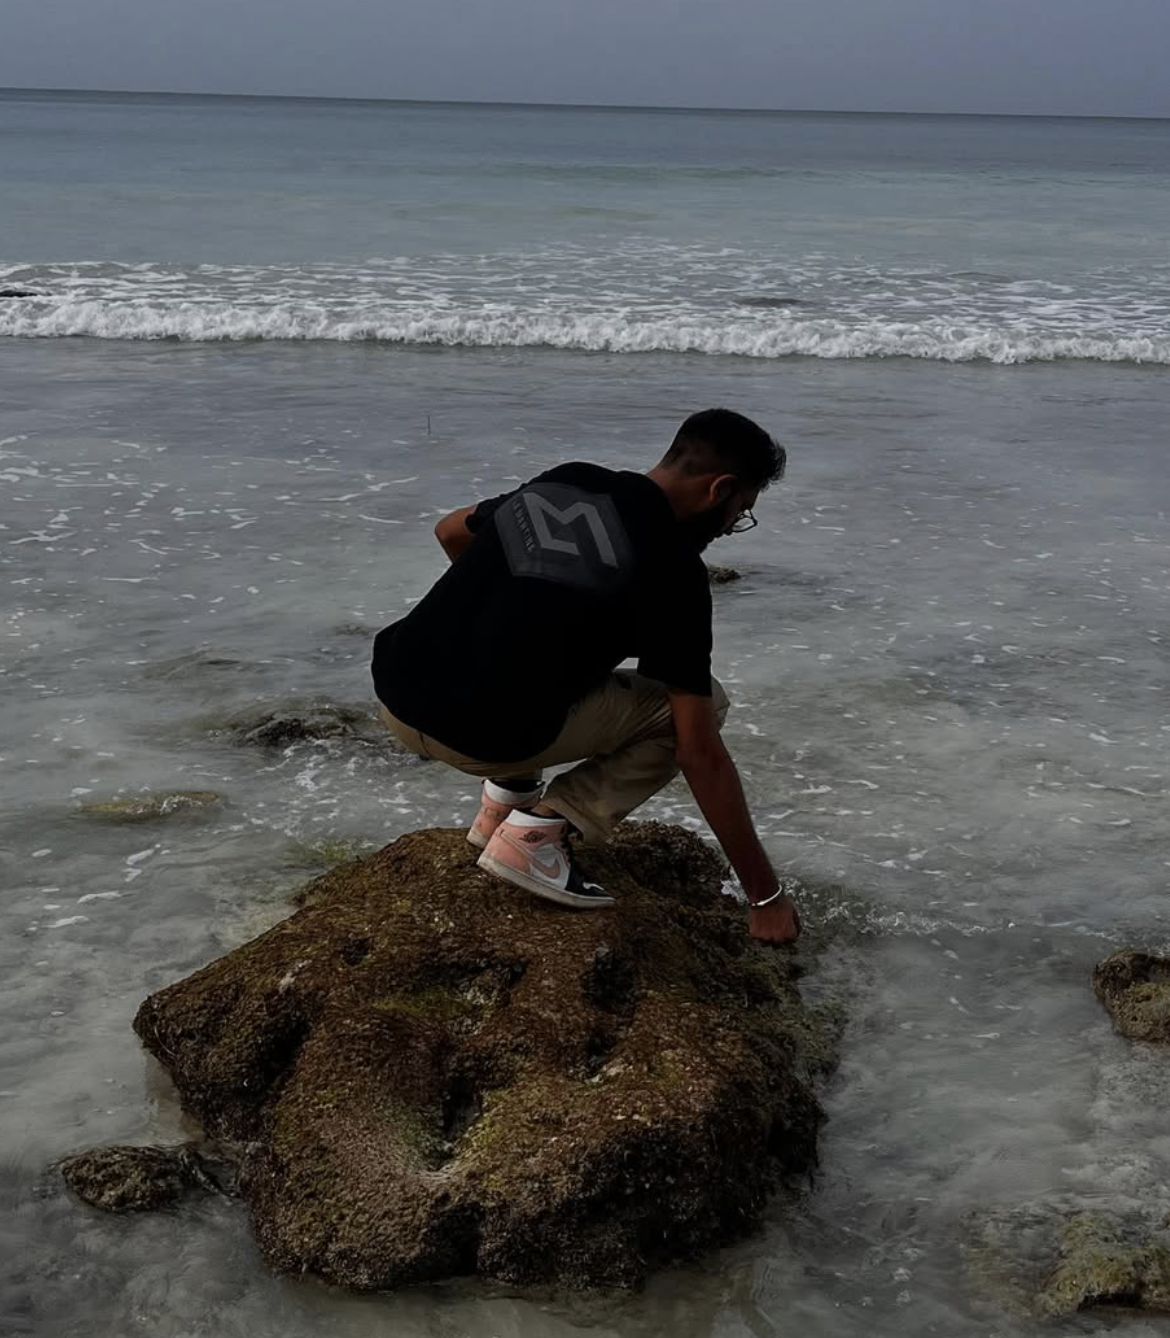

['man in shirt a in ocean water the to a of water a by',
 'man a on beach a on face sunset sunset sunset sunset a sunset sunset',
 'man a is in of with on rock a sunset sunset the sunset sunset',
 'young in is on beach the water sunset sunset a sunset sunset the of',
 'man a in shirt on sandyside the of ocean sunset the water a']

In [19]:
captions, generated, image_matrix = caption_image(  # Out of sample photo
    finetuned_model, '../../data/me.png'
)

captions

In [29]:
# Analyzing for top non stopwords words in corpus

vec = CountVectorizer(stop_words='english')

bag_of_words = vec.fit_transform(image_df['caption'])

sum_words = bag_of_words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

sorted(words_freq, key = lambda x: x[1], reverse=True)[:20]

[('dog', np.int64(4093)),
 ('man', np.int64(2859)),
 ('boy', np.int64(1597)),
 ('dogs', np.int64(1378)),
 ('water', np.int64(1315)),
 ('girl', np.int64(1305)),
 ('black', np.int64(1221)),
 ('people', np.int64(1154)),
 ('playing', np.int64(1098)),
 ('running', np.int64(1083)),
 ('woman', np.int64(1078)),
 ('white', np.int64(1070)),
 ('young', np.int64(974)),
 ('brown', np.int64(926)),
 ('snow', np.int64(825)),
 ('grass', np.int64(742)),
 ('jumping', np.int64(682)),
 ('red', np.int64(679)),
 ('ball', np.int64(678)),
 ('child', np.int64(662))]

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


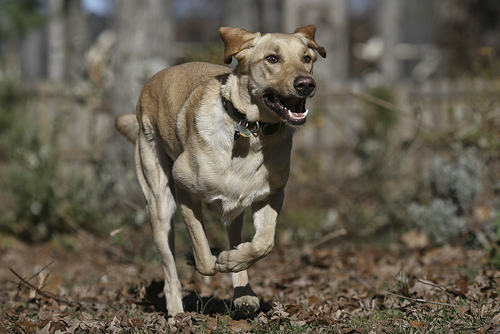

['brown black running a iny , in field grass the black white is',
 'dog a across grass the at edge the of field grass the dog his',
 'dogs in field grass in field grass a dog to mouth the on other',
 'grey brown is across field grass grass the dog running the grass the grass',
 'dog through fence path dog on grass a hill grass yard dogs the']

In [21]:
captions, generated, image_matrix = caption_image(  # from our flicker dataset
    finetuned_model, 
    '../../data/flicker_images/3148647065_2d6cd88cf6.jpg'
)
captions

In [43]:
non_finetuned = VisionEncoderDecoderModel.from_encoder_decoder_pretrained('google/vit-base-patch16-224-in21k', 'distilgpt2')

loading configuration file config.json from cache at /Users/niketgirdhar/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/b4569560a39a0f1af58e3ddaf17facf20ab919b0/config.json
Model config ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "transformers_version": "4.53.0"
}

loading weights file model.safetensors from cache at /Users/niketgirdhar/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/b4569560a39a0f1af58e3ddaf17facf20ab919b0/model.safetensors
All model checkpoint weights were used when init

The following generation flags are not valid and may be ignored: ['early_stopping'].
- `early_stopping`: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
If you're using a pretrained model, note that some of these attributes may be set through the model's `generation_config.json` file.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


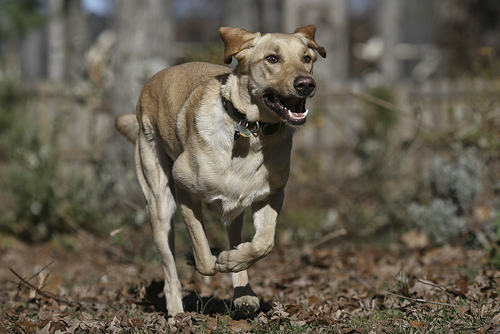

['A former senior aide to Sen. Bernie Sanders and his allies in',
 'the game is very good for you, I hope you like the story',
 'The National Security Agency is investigating a cyberattack on the Democratic National Committee',
 ', it’s time for the people.’',
 'The new law, which allows companies to deny access to the internet']

In [44]:
# Sanity check that a pretrained model alone couldn't do this

captions, generated, image_matrix = caption_image(
    non_finetuned, '../../data/flicker_images/3148647065_2d6cd88cf6.jpg'
)
captions